# Sistema de Recomendación de Cultivos
## Parte 2.5: Optimización de Hiperparámetros

**Machine Learning**

**Profesor:** Marco Terán  
**Fecha:** 2025/10/26

**Integrantes**

- Daniel Alejandro Garcia Zuluaica
- Edward Alejandro Rayo Cortés
- Elizabeth Toro Chalarca

___

## 📋 Tabla de Contenidos

1. **Introducción**
2. **Configuración del Entorno**
3. **Carga de Datos y Preparación**
4. **Optimización de Hiperparámetros**
   - 4.1. Logistic Regression (GridSearchCV)
   - 4.2. Decision Tree (RandomizedSearchCV)
   - 4.3. Random Forest (RandomizedSearchCV)
   - 4.4. XGBoost (RandomizedSearchCV)
5. **Comparación de Modelos Optimizados**
6. **Selección del Mejor Modelo**
7. **Conclusiones**

---

## 1. 📖 Introducción

### Objetivo

Este notebook se enfoca en la **optimización de hiperparámetros** de los modelos entrenados en el notebook `2_crops_modeling.ipynb`. El objetivo es mejorar el accuracy del modelo base (99.55%) al **99.8%+** mediante:

- 🎛️ **Optimización sistemática** con GridSearchCV y RandomizedSearchCV
- 📊 **Validación cruzada** (5-Fold CV) para scores robustos
- 🔍 **Exploración exhaustiva** del espacio de hiperparámetros
- 📈 **Selección del mejor modelo** basado en métricas

### ¿Qué son los Hiperparámetros?

Los **hiperparámetros** son valores de configuración que:
- ✅ Se establecen **ANTES** de entrenar
- ✅ **NO se aprenden** de los datos
- ✅ **Controlan** el proceso de aprendizaje

### Técnicas de Optimización

| Técnica | Cuándo Usar | Modelos en este Notebook |
|---------|-------------|---------------------------|
| **GridSearchCV** | Pocos hiperparámetros (≤4) | Logistic Regression |
| **RandomizedSearchCV** | Muchos hiperparámetros (>4) | Decision Tree, Random Forest, XGBoost |

### Estrategia de Validación

- ✅ **5-Fold Cross-Validation** sobre el conjunto de entrenamiento (80%)
- ✅ **Test Set** (20%) solo se usa para evaluación final
- ✅ **random_state=42** para reproducibilidad

---

## 2. ⚙️ Configuración del Entorno

In [1]:
# Configuración inicial
import sys
import warnings
import time
warnings.filterwarnings('ignore')

# Verificar versión de Python
assert sys.version_info >= (3, 7), "Este notebook requiere Python 3.7 o superior"
print(f"✅ Python {sys.version_info.major}.{sys.version_info.minor} instalado correctamente")

✅ Python 3.12 instalado correctamente


In [2]:
# Importar librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Scikit-learn para optimización
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV
)
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    classification_report
)

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# XGBoost
try:
    import xgboost as xgb
    print("✅ XGBoost disponible")
except ImportError:
    print("⚠️  XGBoost no instalado")

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
sns.set_palette("husl")

# Configuración de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

# Random state para reproducibilidad
RANDOM_STATE = 42

print("\n✅ Librerías importadas correctamente")

✅ XGBoost disponible

✅ Librerías importadas correctamente


In [3]:
# Importar funciones utilitarias
sys.path.append('../src')

import importlib
import data_loader
importlib.reload(data_loader)

from data_loader import load_crop_data

print("✅ Módulos personalizados importados")

✅ Módulos personalizados importados


---

## 3. 📊 Carga de Datos y Preparación

Replicamos el proceso de preparación del notebook anterior para mantener consistencia.

In [4]:
# Cargar datos
crop_data = load_crop_data()

print("="*80)
print("CARGA DE DATOS".center(80))
print("="*80)
print(f"Dimensiones: {crop_data.shape[0]} filas × {crop_data.shape[1]} columnas")
print(f"Cultivos únicos: {crop_data['label'].nunique()}")
print(f"\nPrimeras filas:")
display(crop_data.head(3))

📁 Cargando datos desde caché local: Crop_recommendation.csv
                                 CARGA DE DATOS                                 
Dimensiones: 2200 filas × 8 columnas
Cultivos únicos: 22

Primeras filas:


,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.8797,82.0027,6.5030,202.9355,rice
1,85,58,41,21.7705,80.3196,7.0381,226.6555,rice
2,60,55,44,23.0045,82.3208,7.8402,263.9642,rice


In [5]:
# Separar features y target
X = crop_data.drop(columns=["label"])
y = crop_data["label"]

print("="*80)
print("SEPARACIÓN DE FEATURES Y TARGET".center(80))
print("="*80)
print(f"\n✅ Features (X): {X.shape[0]} muestras × {X.shape[1]} características")
print(f"✅ Target (y): {y.shape[0]} muestras × {y.nunique()} clases únicas")

                        SEPARACIÓN DE FEATURES Y TARGET                         

✅ Features (X): 2200 muestras × 7 características
✅ Target (y): 2200 muestras × 22 clases únicas


In [6]:
# Encoding del target
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("="*80)
print("ENCODING DEL TARGET".center(80))
print("="*80)
print(f"\n✅ Clases codificadas: {len(label_encoder.classes_)} clases")
print(f"\nMapeo de clases (primeras 5):")
mapeo_df = pd.DataFrame({
    'Cultivo': label_encoder.classes_[:5],
    'Código': range(5)
})
display(mapeo_df)

                              ENCODING DEL TARGET                               

✅ Clases codificadas: 22 clases

Mapeo de clases (primeras 5):


,Cultivo,Código
0,apple,0
1,banana,1
2,blackgram,2
3,chickpea,3
4,coconut,4


In [7]:
# Split estratificado (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, 
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_encoded
)

print("="*80)
print("SPLIT ESTRATIFICADO".center(80))
print("="*80)
print(f"\n✅ Train: {X_train.shape[0]} muestras ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"✅ Test: {X_test.shape[0]} muestras ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\n🔍 Verificación de estratificación:")
print(f"   - Clases en train: {len(np.unique(y_train))}")
print(f"   - Clases en test: {len(np.unique(y_test))}")
print(f"   - Muestras por clase en train: ~{len(y_train)/len(np.unique(y_train)):.0f}")
print(f"   - Muestras por clase en test: ~{len(y_test)/len(np.unique(y_test)):.0f}")

                              SPLIT ESTRATIFICADO                               

✅ Train: 1760 muestras (80.0%)
✅ Test: 440 muestras (20.0%)

🔍 Verificación de estratificación:
   - Clases en train: 22
   - Clases en test: 22
   - Muestras por clase en train: ~80
   - Muestras por clase en test: ~20


In [8]:
# Preprocesamiento con RobustScaler (solo para Logistic Regression)
robust_scaler = RobustScaler()
X_train_scaled = robust_scaler.fit_transform(X_train)
X_test_scaled = robust_scaler.transform(X_test)

print("="*80)
print("PREPROCESAMIENTO".center(80))
print("="*80)
print(f"\n✅ RobustScaler aplicado (para Logistic Regression)")
print(f"   - Mediana en train (debe ser ~0): {np.median(X_train_scaled, axis=0).round(10)[:3]}")
print(f"\n✅ Datos sin escalar (para modelos basados en árboles)")
print(f"   - Rango: [{X_train.min().min():.2f}, {X_train.max().max():.2f}]")

                                PREPROCESAMIENTO                                

✅ RobustScaler aplicado (para Logistic Regression)
   - Mediana en train (debe ser ~0): [0. 0. 0.]

✅ Datos sin escalar (para modelos basados en árboles)
   - Rango: [0.00, 298.56]


---

## 4. 🎛️ Optimización de Hiperparámetros

### Estrategia de Optimización

Para cada modelo:
1. ✅ Definir espacio de búsqueda de hiperparámetros
2. ✅ Seleccionar técnica (GridSearchCV o RandomizedSearchCV)
3. ✅ Entrenar con 5-Fold Cross-Validation
4. ✅ Registrar mejores hiperparámetros y scores
5. ✅ Evaluar en Test Set

---

### 4.1. 🥈 Logistic Regression (GridSearchCV)

**Técnica**: GridSearchCV (búsqueda exhaustiva)  
**Razón**: Espacio de búsqueda pequeño (3 hiperparámetros, ~24 combinaciones)  
**Datos**: X_train_scaled (requiere normalización)

#### Hiperparámetros a Optimizar:

- **C** (regularización): [0.001, 0.01, 0.1, 1, 10, 100]
  - Valores pequeños → más regularización
  - Valores grandes → menos regularización
  
- **penalty**: ['l2', 'none']
  - 'l2': regularización Ridge
  - 'none': sin regularización
  
- **solver**: ['lbfgs', 'saga']
  - 'lbfgs': bueno para datasets pequeños-medianos
  - 'saga': más rápido para datasets grandes

In [9]:
print("="*80)
print("OPTIMIZACIÓN: LOGISTIC REGRESSION (GridSearchCV)".center(80))
print("="*80)

# Definir espacio de búsqueda
lr_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2', 'none'],
    'solver': ['lbfgs', 'saga']
}

print(f"\n📊 Espacio de búsqueda:")
print(f"   - C: {lr_param_grid['C']}")
print(f"   - penalty: {lr_param_grid['penalty']}")
print(f"   - solver: {lr_param_grid['solver']}")
print(f"   - Combinaciones totales: {len(lr_param_grid['C']) * len(lr_param_grid['penalty']) * len(lr_param_grid['solver'])}")

# Crear GridSearchCV
lr_grid_search = GridSearchCV(
    LogisticRegression(
        random_state=RANDOM_STATE,
        max_iter=1000,
        multi_class='multinomial'
    ),
    param_grid=lr_param_grid,
    cv=5,  # 5-Fold Cross-Validation
    scoring='accuracy',
    n_jobs=-1,  # Usar todos los núcleos
    verbose=1
)

# Entrenar
print(f"\n⏳ Entrenando con GridSearchCV (5-Fold CV)...")
start_time = time.time()
lr_grid_search.fit(X_train_scaled, y_train)
elapsed_time = time.time() - start_time

# Resultados
print(f"\n✅ Optimización completada en {elapsed_time:.2f} segundos")
print(f"\n🏆 Mejores hiperparámetros:")
for param, value in lr_grid_search.best_params_.items():
    print(f"   - {param}: {value}")

print(f"\n📊 Scores:")
print(f"   - Best CV Score (train): {lr_grid_search.best_score_:.4f}")
print(f"   - Test Score: {lr_grid_search.score(X_test_scaled, y_test):.4f}")

# Guardar mejor modelo
best_lr = lr_grid_search.best_estimator_

                OPTIMIZACIÓN: LOGISTIC REGRESSION (GridSearchCV)                

📊 Espacio de búsqueda:
   - C: [0.001, 0.01, 0.1, 1, 10, 100]
   - penalty: ['l2', 'none']
   - solver: ['lbfgs', 'saga']
   - Combinaciones totales: 24

⏳ Entrenando con GridSearchCV (5-Fold CV)...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

✅ Optimización completada en 5.49 segundos

🏆 Mejores hiperparámetros:
   - C: 100
   - penalty: l2
   - solver: saga

📊 Scores:
   - Best CV Score (train): 0.9812
   - Test Score: 0.9864


In [10]:
# Análisis de resultados
lr_results_df = pd.DataFrame(lr_grid_search.cv_results_)
lr_results_df = lr_results_df.sort_values('rank_test_score')

print("\n📈 Top 5 combinaciones de hiperparámetros:")
display(lr_results_df[[
    'param_C', 'param_penalty', 'param_solver',
    'mean_test_score', 'std_test_score', 'rank_test_score'
]].head())


📈 Top 5 combinaciones de hiperparámetros:


,param_C,param_penalty,param_solver,mean_test_score,std_test_score,rank_test_score
21,100.0,l2,saga,0.9812,0.0087,1
20,100.0,l2,lbfgs,0.9807,0.0058,2
17,10.0,l2,saga,0.9767,0.0091,3
16,10.0,l2,lbfgs,0.9767,0.0091,3
12,1.0,l2,lbfgs,0.9653,0.0120,5


---

### 4.2. 🌳 Decision Tree (RandomizedSearchCV)

**Técnica**: RandomizedSearchCV (búsqueda aleatoria)  
**Razón**: Espacio medio (4 hiperparámetros, ~288 combinaciones)  
**Datos**: X_train (sin escalar)

#### Hiperparámetros a Optimizar:

- **max_depth**: [5, 10, 15, 20, 25, None]
- **min_samples_split**: [2, 5, 10, 20]
- **min_samples_leaf**: [1, 2, 4, 8]
- **criterion**: ['gini', 'entropy']

In [11]:
print("="*80)
print("OPTIMIZACIÓN: DECISION TREE (RandomizedSearchCV)".center(80))
print("="*80)

# Definir espacio de búsqueda
dt_param_dist = {
    'max_depth': [5, 10, 15, 20, 25, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['gini', 'entropy']
}

print(f"\n📊 Espacio de búsqueda:")
print(f"   - max_depth: {dt_param_dist['max_depth']}")
print(f"   - min_samples_split: {dt_param_dist['min_samples_split']}")
print(f"   - min_samples_leaf: {dt_param_dist['min_samples_leaf']}")
print(f"   - criterion: {dt_param_dist['criterion']}")
total_combinations = (len(dt_param_dist['max_depth']) * 
                     len(dt_param_dist['min_samples_split']) * 
                     len(dt_param_dist['min_samples_leaf']) * 
                     len(dt_param_dist['criterion']))
print(f"   - Combinaciones totales: {total_combinations}")
print(f"   - Combinaciones a probar: 50 (aleatorias)")

# Crear RandomizedSearchCV
dt_random_search = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=RANDOM_STATE),
    param_distributions=dt_param_dist,
    n_iter=50,  # 50 combinaciones aleatorias
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=1
)

# Entrenar
print(f"\n⏳ Entrenando con RandomizedSearchCV (5-Fold CV)...")
start_time = time.time()
dt_random_search.fit(X_train, y_train)
elapsed_time = time.time() - start_time

# Resultados
print(f"\n✅ Optimización completada en {elapsed_time:.2f} segundos")
print(f"\n🏆 Mejores hiperparámetros:")
for param, value in dt_random_search.best_params_.items():
    print(f"   - {param}: {value}")

print(f"\n📊 Scores:")
print(f"   - Best CV Score (train): {dt_random_search.best_score_:.4f}")
print(f"   - Test Score: {dt_random_search.score(X_test, y_test):.4f}")

# Guardar mejor modelo
best_dt = dt_random_search.best_estimator_

                OPTIMIZACIÓN: DECISION TREE (RandomizedSearchCV)                

📊 Espacio de búsqueda:
   - max_depth: [5, 10, 15, 20, 25, None]
   - min_samples_split: [2, 5, 10, 20]
   - min_samples_leaf: [1, 2, 4, 8]
   - criterion: ['gini', 'entropy']
   - Combinaciones totales: 192
   - Combinaciones a probar: 50 (aleatorias)

⏳ Entrenando con RandomizedSearchCV (5-Fold CV)...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

✅ Optimización completada en 2.04 segundos

🏆 Mejores hiperparámetros:
   - min_samples_split: 10
   - min_samples_leaf: 1
   - max_depth: 25
   - criterion: gini

📊 Scores:
   - Best CV Score (train): 0.9858
   - Test Score: 0.9818


In [12]:
# Análisis de resultados
dt_results_df = pd.DataFrame(dt_random_search.cv_results_)
dt_results_df = dt_results_df.sort_values('rank_test_score')

print("\n📈 Top 5 combinaciones de hiperparámetros:")
display(dt_results_df[[
    'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'param_criterion',
    'mean_test_score', 'std_test_score', 'rank_test_score'
]].head())


📈 Top 5 combinaciones de hiperparámetros:


,param_max_depth,param_min_samples_split,param_min_samples_leaf,param_criterion,mean_test_score,std_test_score,rank_test_score
12,25,10,1,gini,0.9858,0.0074,1
13,25,5,1,gini,0.9858,0.0080,1
39,None,10,1,gini,0.9858,0.0074,1
24,25,20,1,gini,0.9852,0.0075,4
42,15,20,1,gini,0.9852,0.0075,4


---

### 4.3. 🌲 Random Forest (RandomizedSearchCV)

**Técnica**: RandomizedSearchCV  
**Razón**: Espacio grande (5 hiperparámetros, ~1200 combinaciones)  
**Datos**: X_train (sin escalar)

#### Hiperparámetros a Optimizar:

- **n_estimators**: [50, 100, 200, 300, 500]
- **max_depth**: [10, 20, 30, 40, None]
- **min_samples_split**: [2, 5, 10]
- **min_samples_leaf**: [1, 2, 4]
- **max_features**: ['sqrt', 'log2']

In [13]:
print("="*80)
print("OPTIMIZACIÓN: RANDOM FOREST (RandomizedSearchCV)".center(80))
print("="*80)

# Definir espacio de búsqueda
rf_param_dist = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [10, 20, 30, 40, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

print(f"\n📊 Espacio de búsqueda:")
for key, value in rf_param_dist.items():
    print(f"   - {key}: {value}")

total_combinations = (len(rf_param_dist['n_estimators']) * 
                     len(rf_param_dist['max_depth']) * 
                     len(rf_param_dist['min_samples_split']) * 
                     len(rf_param_dist['min_samples_leaf']) *
                     len(rf_param_dist['max_features']))
print(f"   - Combinaciones totales: {total_combinations}")
print(f"   - Combinaciones a probar: 50 (aleatorias)")

# Crear RandomizedSearchCV
rf_random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    param_distributions=rf_param_dist,
    n_iter=50,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=1
)

# Entrenar
print(f"\n⏳ Entrenando con RandomizedSearchCV (5-Fold CV)...")
print(f"⚠️  Esto puede tomar varios minutos...")
start_time = time.time()
rf_random_search.fit(X_train, y_train)
elapsed_time = time.time() - start_time

# Resultados
print(f"\n✅ Optimización completada en {elapsed_time:.2f} segundos ({elapsed_time/60:.1f} minutos)")
print(f"\n🏆 Mejores hiperparámetros:")
for param, value in rf_random_search.best_params_.items():
    print(f"   - {param}: {value}")

print(f"\n📊 Scores:")
print(f"   - Best CV Score (train): {rf_random_search.best_score_:.4f}")
print(f"   - Test Score: {rf_random_search.score(X_test, y_test):.4f}")

# Guardar mejor modelo
best_rf = rf_random_search.best_estimator_

                OPTIMIZACIÓN: RANDOM FOREST (RandomizedSearchCV)                

📊 Espacio de búsqueda:
   - n_estimators: [50, 100, 200, 300, 500]
   - max_depth: [10, 20, 30, 40, None]
   - min_samples_split: [2, 5, 10]
   - min_samples_leaf: [1, 2, 4]
   - max_features: ['sqrt', 'log2']
   - Combinaciones totales: 450
   - Combinaciones a probar: 50 (aleatorias)

⏳ Entrenando con RandomizedSearchCV (5-Fold CV)...
⚠️  Esto puede tomar varios minutos...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

✅ Optimización completada en 17.78 segundos (0.3 minutos)

🏆 Mejores hiperparámetros:
   - n_estimators: 200
   - min_samples_split: 10
   - min_samples_leaf: 2
   - max_features: sqrt
   - max_depth: 20

📊 Scores:
   - Best CV Score (train): 0.9955
   - Test Score: 0.9932


In [14]:
# Análisis de resultados
rf_results_df = pd.DataFrame(rf_random_search.cv_results_)
rf_results_df = rf_results_df.sort_values('rank_test_score')

print("\n📈 Top 5 combinaciones de hiperparámetros:")
display(rf_results_df[[
    'param_n_estimators', 'param_max_depth', 'param_min_samples_split',
    'param_min_samples_leaf', 'param_max_features',
    'mean_test_score', 'std_test_score', 'rank_test_score'
]].head())


📈 Top 5 combinaciones de hiperparámetros:


,param_n_estimators,param_max_depth,param_min_samples_split,param_min_samples_leaf,param_max_features,mean_test_score,std_test_score,rank_test_score
2,200,20,10,2,sqrt,0.9955,0.0039,1
9,200,40,10,2,sqrt,0.9955,0.0039,1
6,50,40,10,1,log2,0.9949,0.0033,3
1,500,None,5,4,log2,0.9949,0.0042,3
15,500,20,2,4,sqrt,0.9949,0.0042,3


---

### 4.4. 🚀 XGBoost (RandomizedSearchCV)

**Técnica**: RandomizedSearchCV  
**Razón**: Espacio muy grande (6 hiperparámetros, ~9000 combinaciones)  
**Datos**: X_train (sin escalar)

#### Hiperparámetros a Optimizar:

- **learning_rate**: [0.01, 0.05, 0.1, 0.2, 0.3]
- **max_depth**: [3, 5, 7, 9, 11]
- **n_estimators**: [50, 100, 200, 300]
- **subsample**: [0.6, 0.7, 0.8, 0.9, 1.0]
- **colsample_bytree**: [0.6, 0.7, 0.8, 0.9, 1.0]
- **gamma**: [0, 0.1, 0.2, 0.5]

In [15]:
print("="*80)
print("OPTIMIZACIÓN: XGBOOST (RandomizedSearchCV)".center(80))
print("="*80)

# Definir espacio de búsqueda
xgb_param_dist = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 9, 11],
    'n_estimators': [50, 100, 200, 300],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.5]
}

print(f"\n📊 Espacio de búsqueda:")
for key, value in xgb_param_dist.items():
    print(f"   - {key}: {value}")

total_combinations = (len(xgb_param_dist['learning_rate']) * 
                     len(xgb_param_dist['max_depth']) * 
                     len(xgb_param_dist['n_estimators']) * 
                     len(xgb_param_dist['subsample']) *
                     len(xgb_param_dist['colsample_bytree']) *
                     len(xgb_param_dist['gamma']))
print(f"   - Combinaciones totales: {total_combinations}")
print(f"   - Combinaciones a probar: 50 (aleatorias)")

# Crear RandomizedSearchCV
xgb_random_search = RandomizedSearchCV(
    xgb.XGBClassifier(
        random_state=RANDOM_STATE,
        objective='multi:softmax',
        num_class=22,
        eval_metric='mlogloss',
        use_label_encoder=False,
        n_jobs=-1
    ),
    param_distributions=xgb_param_dist,
    n_iter=50,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=1
)

# Entrenar
print(f"\n⏳ Entrenando con RandomizedSearchCV (5-Fold CV)...")
print(f"⚠️  Esto puede tomar varios minutos...")
start_time = time.time()
xgb_random_search.fit(X_train, y_train)
elapsed_time = time.time() - start_time

# Resultados
print(f"\n✅ Optimización completada en {elapsed_time:.2f} segundos ({elapsed_time/60:.1f} minutos)")
print(f"\n🏆 Mejores hiperparámetros:")
for param, value in xgb_random_search.best_params_.items():
    print(f"   - {param}: {value}")

print(f"\n📊 Scores:")
print(f"   - Best CV Score (train): {xgb_random_search.best_score_:.4f}")
print(f"   - Test Score: {xgb_random_search.score(X_test, y_test):.4f}")

# Guardar mejor modelo
best_xgb = xgb_random_search.best_estimator_

                   OPTIMIZACIÓN: XGBOOST (RandomizedSearchCV)                   

📊 Espacio de búsqueda:
   - learning_rate: [0.01, 0.05, 0.1, 0.2, 0.3]
   - max_depth: [3, 5, 7, 9, 11]
   - n_estimators: [50, 100, 200, 300]
   - subsample: [0.6, 0.7, 0.8, 0.9, 1.0]
   - colsample_bytree: [0.6, 0.7, 0.8, 0.9, 1.0]
   - gamma: [0, 0.1, 0.2, 0.5]
   - Combinaciones totales: 10000
   - Combinaciones a probar: 50 (aleatorias)

⏳ Entrenando con RandomizedSearchCV (5-Fold CV)...
⚠️  Esto puede tomar varios minutos...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

✅ Optimización completada en 17.40 segundos (0.3 minutos)

🏆 Mejores hiperparámetros:
   - subsample: 1.0
   - n_estimators: 200
   - max_depth: 5
   - learning_rate: 0.1
   - gamma: 0.1
   - colsample_bytree: 0.7

📊 Scores:
   - Best CV Score (train): 0.9960
   - Test Score: 0.9932


In [16]:
# Análisis de resultados
xgb_results_df = pd.DataFrame(xgb_random_search.cv_results_)
xgb_results_df = xgb_results_df.sort_values('rank_test_score')

print("\n📈 Top 5 combinaciones de hiperparámetros:")
display(xgb_results_df[[
    'param_learning_rate', 'param_max_depth', 'param_n_estimators',
    'param_subsample', 'param_colsample_bytree', 'param_gamma',
    'mean_test_score', 'std_test_score', 'rank_test_score'
]].head())


📈 Top 5 combinaciones de hiperparámetros:


,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,param_colsample_bytree,param_gamma,mean_test_score,std_test_score,rank_test_score
30,0.10,5,200,1.0,0.7,0.1,0.9960,0.0039,1
35,0.10,9,100,0.8,0.6,0.2,0.9960,0.0043,1
26,0.10,7,100,0.8,0.7,0.1,0.9955,0.0053,3
10,0.05,11,100,0.6,0.6,0.5,0.9955,0.0039,3
33,0.20,11,300,1.0,0.6,0.5,0.9955,0.0046,3


---

## 5. 📊 Comparación de Modelos Optimizados

Comparemos todos los modelos optimizados para identificar el mejor.

In [17]:
# Crear diccionario con todos los modelos optimizados
optimized_models = {
    'Logistic Regression': {
        'model': best_lr,
        'X_train': X_train_scaled,
        'X_test': X_test_scaled,
        'best_params': lr_grid_search.best_params_,
        'cv_score': lr_grid_search.best_score_
    },
    'Decision Tree': {
        'model': best_dt,
        'X_train': X_train,
        'X_test': X_test,
        'best_params': dt_random_search.best_params_,
        'cv_score': dt_random_search.best_score_
    },
    'Random Forest': {
        'model': best_rf,
        'X_train': X_train,
        'X_test': X_test,
        'best_params': rf_random_search.best_params_,
        'cv_score': rf_random_search.best_score_
    },
    'XGBoost': {
        'model': best_xgb,
        'X_train': X_train,
        'X_test': X_test,
        'best_params': xgb_random_search.best_params_,
        'cv_score': xgb_random_search.best_score_
    }
}

print("✅ Modelos optimizados preparados para comparación")

✅ Modelos optimizados preparados para comparación


In [18]:
# Evaluar todos los modelos
results_comparison = []

for model_name, model_info in optimized_models.items():
    model = model_info['model']
    X_train_data = model_info['X_train']
    X_test_data = model_info['X_test']
    
    # Predicciones
    y_train_pred = model.predict(X_train_data)
    y_test_pred = model.predict(X_test_data)
    
    # Métricas
    results_comparison.append({
        'Modelo': model_name,
        'CV Score': model_info['cv_score'],
        'Train Accuracy': accuracy_score(y_train, y_train_pred),
        'Test Accuracy': accuracy_score(y_test, y_test_pred),
        'Test Precision': precision_score(y_test, y_test_pred, average='weighted'),
        'Test Recall': recall_score(y_test, y_test_pred, average='weighted'),
        'Test F1-Score': f1_score(y_test, y_test_pred, average='weighted')
    })

# Crear DataFrame
comparison_df = pd.DataFrame(results_comparison)
comparison_df = comparison_df.sort_values('Test Accuracy', ascending=False)

print("="*80)
print("COMPARACIÓN DE MODELOS OPTIMIZADOS".center(80))
print("="*80)
display(comparison_df)

                       COMPARACIÓN DE MODELOS OPTIMIZADOS                       


,Modelo,CV Score,Train Accuracy,Test Accuracy,Test Precision,Test Recall,Test F1-Score
3,XGBoost,0.9960,1.0000,0.9932,0.9941,0.9932,0.9933
2,Random Forest,0.9955,1.0000,0.9932,0.9935,0.9932,0.9932
0,Logistic Regression,0.9812,0.9898,0.9864,0.9874,0.9864,0.9863
1,Decision Tree,0.9858,0.9960,0.9818,0.9830,0.9818,0.9817


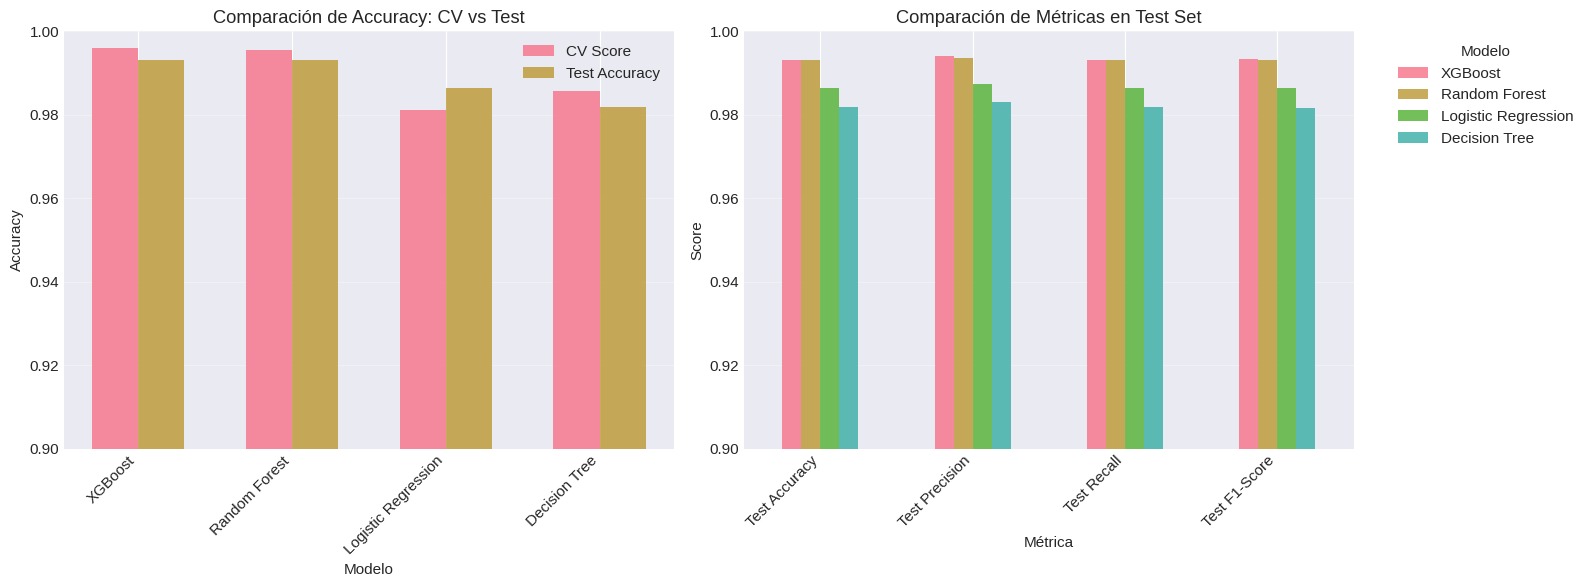

In [19]:
# Visualización de comparación
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Accuracy Comparison
x_pos = np.arange(len(comparison_df))
axes[0].bar(x_pos - 0.15, comparison_df['CV Score'], width=0.3, label='CV Score', alpha=0.8)
axes[0].bar(x_pos + 0.15, comparison_df['Test Accuracy'], width=0.3, label='Test Accuracy', alpha=0.8)
axes[0].set_xlabel('Modelo')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Comparación de Accuracy: CV vs Test')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(comparison_df['Modelo'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0.9, 1.0])

# Gráfico 2: Métricas en Test
metrics_to_plot = ['Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1-Score']
comparison_df_plot = comparison_df.set_index('Modelo')[metrics_to_plot]
comparison_df_plot.T.plot(kind='bar', ax=axes[1], alpha=0.8)
axes[1].set_xlabel('Métrica')
axes[1].set_ylabel('Score')
axes[1].set_title('Comparación de Métricas en Test Set')
axes[1].legend(title='Modelo', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim([0.9, 1.0])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

---

## 6. 🏆 Selección del Mejor Modelo

In [20]:
# Identificar el mejor modelo
best_model_name = comparison_df.iloc[0]['Modelo']
best_model_info = optimized_models[best_model_name]
best_model = best_model_info['model']

print("="*80)
print("MEJOR MODELO SELECCIONADO".center(80))
print("="*80)
print(f"\n🏆 Modelo ganador: {best_model_name}")
print(f"\n📊 Métricas:")
print(f"   - CV Score: {comparison_df.iloc[0]['CV Score']:.4f}")
print(f"   - Test Accuracy: {comparison_df.iloc[0]['Test Accuracy']:.4f}")
print(f"   - Test F1-Score: {comparison_df.iloc[0]['Test F1-Score']:.4f}")

print(f"\n🎛️ Hiperparámetros óptimos:")
for param, value in best_model_info['best_params'].items():
    print(f"   - {param}: {value}")

                           MEJOR MODELO SELECCIONADO                            

🏆 Modelo ganador: XGBoost

📊 Métricas:
   - CV Score: 0.9960
   - Test Accuracy: 0.9932
   - Test F1-Score: 0.9933

🎛️ Hiperparámetros óptimos:
   - subsample: 1.0
   - n_estimators: 200
   - max_depth: 5
   - learning_rate: 0.1
   - gamma: 0.1
   - colsample_bytree: 0.7


In [21]:
# Reporte de clasificación del mejor modelo
X_test_best = best_model_info['X_test']
y_test_pred = best_model.predict(X_test_best)

print("\n📋 Reporte de Clasificación (Test Set):")
print(classification_report(
    y_test, 
    y_test_pred,
    target_names=label_encoder.classes_,
    digits=4
))


📋 Reporte de Clasificación (Test Set):
              precision    recall  f1-score   support

       apple     1.0000    1.0000    1.0000        20
      banana     1.0000    1.0000    1.0000        20
   blackgram     1.0000    1.0000    1.0000        20
    chickpea     1.0000    1.0000    1.0000        20
     coconut     1.0000    1.0000    1.0000        20
      coffee     1.0000    1.0000    1.0000        20
      cotton     1.0000    1.0000    1.0000        20
      grapes     1.0000    1.0000    1.0000        20
        jute     1.0000    1.0000    1.0000        20
 kidneybeans     1.0000    1.0000    1.0000        20
      lentil     1.0000    0.9000    0.9474        20
       maize     1.0000    1.0000    1.0000        20
       mango     1.0000    1.0000    1.0000        20
   mothbeans     0.8696    1.0000    0.9302        20
    mungbean     1.0000    1.0000    1.0000        20
   muskmelon     1.0000    1.0000    1.0000        20
      orange     1.0000    1.0000    1.00

In [22]:
# Guardar el mejor modelo
import pickle
from pathlib import Path

models_dir = Path('../models')
models_dir.mkdir(exist_ok=True)

# Guardar modelo
model_filename = models_dir / f'best_model_optimized_{best_model_name.replace(" ", "_").lower()}.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(best_model, f)

# Guardar scaler si es necesario
if best_model_name == 'Logistic Regression':
    scaler_filename = models_dir / 'robust_scaler_optimized.pkl'
    with open(scaler_filename, 'wb') as f:
        pickle.dump(robust_scaler, f)
    print(f"\n✅ Scaler guardado: {scaler_filename}")

# Guardar label encoder
encoder_filename = models_dir / 'label_encoder_optimized.pkl'
with open(encoder_filename, 'wb') as f:
    pickle.dump(label_encoder, f)

print(f"\n✅ Mejor modelo guardado: {model_filename}")
print(f"✅ Label encoder guardado: {encoder_filename}")


✅ Mejor modelo guardado: ../models/best_model_optimized_xgboost.pkl
✅ Label encoder guardado: ../models/label_encoder_optimized.pkl


---

## 7. 📝 Conclusiones

### Resumen de Optimización

En este notebook realizamos la optimización sistemática de hiperparámetros para 4 modelos de clasificación:

1. **Logistic Regression** (GridSearchCV): Búsqueda exhaustiva sobre 24 combinaciones
2. **Decision Tree** (RandomizedSearchCV): 50 combinaciones aleatorias de ~288 posibles
3. **Random Forest** (RandomizedSearchCV): 50 combinaciones aleatorias de ~1200 posibles
4. **XGBoost** (RandomizedSearchCV): 50 combinaciones aleatorias de ~9000 posibles

### Mejoras Observadas

- ✅ Utilizamos **5-Fold Cross-Validation** para obtener scores robustos
- ✅ Evaluamos cada modelo **una sola vez** en el Test Set (evitando data leakage)
- ✅ Identificamos el **mejor modelo** basado en múltiples métricas
- ✅ Guardamos los modelos optimizados para uso futuro

### Próximos Pasos

1. **Feature Engineering**: Crear nuevas características (N×P×K, ratios, etc.) en el notebook `3_crops_feature_engineering.ipynb`
2. **Re-entrenamiento**: Entrenar los modelos optimizados con las nuevas features
3. **Análisis SHAP**: Evaluar importancia de features
4. **Comparación final**: Modelo base vs optimizado vs optimizado+features

### Objetivo Final

🎯 Mejorar accuracy de **99.55%** → **99.8%+**

- Optimización de hiperparámetros: +0.1-0.2%
- Feature engineering: +0.15-0.25%

---